## Setup

In [1]:
# @title Imports and utility functions
import os

import IPython
from IPython.display import display
import numpy as np
import PIL.Image
import pandas as pd
import six

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def imgrid(imarray, cols=8, pad=1):
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant')
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*W, C))
  return grid[:-pad, :-pad]


def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  if six.PY3:
    str_file = six.BytesIO()
  else:
    str_file = six.StringIO()
  PIL.Image.fromarray(a).save(str_file, format)
  png_data = str_file.getvalue()
  try:
    disp = display(IPython.display.Image(png_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp


In [3]:
class Generator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def z_dim(self):
    return self._z.shape[-1].value

  @property
  def conditional(self):
    return self._labels is not None

  def _load_model(self):
    with self._graph.as_default():
        self._generator = hub.load(self._module_spec)

        # Retrieve the structured input signature of the model
        input_signature = self._generator.signatures["default"].structured_input_signature[1]

        # Define input tensors based on expected shapes and types
        inputs = {
            key: tf.zeros(shape=spec.shape, dtype=spec.dtype)
            for key, spec in input_signature.items()
        }

        # Generate a sample output by calling the model with these inputs
        self._samples = self._generator.signatures["default"](**inputs)

        print("Inputs:", inputs)
        print("Generated output:", self._samples)

        # Set self._z and self._labels if present in input keys
        self._z = inputs.get("z")
        self._labels = inputs.get("labels", None)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def get_noise(self, num_samples, seed=None):
    if np.isscalar(seed):
      np.random.seed(seed)
      return np.random.normal(size=[num_samples, self.z_dim])
    z = np.empty(shape=(len(seed), self.z_dim), dtype=np.float32)
    for i, s in enumerate(seed):
      np.random.seed(s)
      z[i] = np.random.normal(size=[self.z_dim])
    return z

  def get_samples(self, z, labels=None):
    with self._graph.as_default():
      self._init_session()

      feed_dict = {self._z: z}
      if self.conditional:
        assert labels is not None
        assert labels.shape[0] == z.shape[0]
        feed_dict[self._labels] = labels

      # Thực hiện suy luận và in ra kết quả trả về từ mô hình
        samples = self._sess.run(self._samples, feed_dict=feed_dict)
        print("Samples dictionary:", samples)  # Xem các khóa trong samples

        # Giả sử đầu ra mong muốn nằm trong khóa 'generated'
        generated_samples = samples["generated"]  # Thay 'generated' bằng tên khóa thực tế
        return np.uint8(np.clip(256 * generated_samples, 0, 255))

      # samples = self._sess.run(self._samples, feed_dict=feed_dict)
      # return np.uint8(np.clip(256 * samples, 0, 255))

## Select a model

In [4]:
# @title Select a model { run: "auto" }

model_name = "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"  # @param ["S3GAN 256x256 10% labels (FID 8.8, IS 130.7)", "S3GAN 128x128 2.5% labels (FID 12.6, IS 48.7)", "S3GAN 128x128 5% labels (FID 8.4, IS 74.0)", "S3GAN 128x128 10% labels (FID 7.6, IS 90.3)", "S3GAN 128x128 20% labels (FID 6.9, IS 98.1)"]
models = {
    "S3GAN 256x256 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_256x256/1",
    "S3GAN 128x128 2.5% labels": "https://tfhub.dev/google/compare_gan/s3gan_2_5_128x128/1",
    "S3GAN 128x128 5% labels": "https://tfhub.dev/google/compare_gan/s3gan_5_128x128/1",
    "S3GAN 128x128 10% labels": "https://tfhub.dev/google/compare_gan/s3gan_10_128x128/1",
    "S3GAN 128x128 20% labels": "https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1",
}

module_spec = models[model_name.split(" (")[0]]
print("Module spec:", module_spec)

tf.reset_default_graph()
# tf.compat.v1.reset_default_graph()
print("Loading model...")
sampler = Generator(module_spec)
print("Model loaded.")

Module spec: https://tfhub.dev/google/compare_gan/s3gan_20_128x128/1
Loading model...
Inputs: {'labels': <tf.Tensor 'zeros:0' shape=(64,) dtype=int32>, 'z': <tf.Tensor 'zeros_1:0' shape=(64, 120) dtype=float32>}
Generated output: {'generated': <tf.Tensor 'StatefulPartitionedCall_1:0' shape=(64, 128, 128, 3) dtype=float32>}
Model loaded.


## Sample

In [5]:
from PIL import Image

def save_samples(samples, filename, cols):
    grid = imgrid(samples, cols=cols)
    img = Image.fromarray(grid)
    img.save(filename)

## Tình huống 1: Sử dụng các tham số mặc định trong code

Samples dictionary: {'generated': array([[[[0.6440299 , 0.6796265 , 0.72625303],
         [0.66415095, 0.7011162 , 0.7670754 ],
         [0.62540203, 0.67223907, 0.7567625 ],
         ...,
         [0.66072774, 0.7041047 , 0.78803205],
         [0.7043155 , 0.75763756, 0.8304657 ],
         [0.73225415, 0.7725279 , 0.8341888 ]],

        [[0.6380861 , 0.66523147, 0.75390255],
         [0.6343003 , 0.6623801 , 0.76438737],
         [0.62040895, 0.6461132 , 0.75711274],
         ...,
         [0.6820978 , 0.7168837 , 0.80343926],
         [0.6763615 , 0.7168904 , 0.8017187 ],
         [0.6961014 , 0.73189825, 0.8064236 ]],

        [[0.6506126 , 0.6606033 , 0.7500798 ],
         [0.63895273, 0.659341  , 0.7476837 ],
         [0.62366927, 0.6390134 , 0.7485332 ],
         ...,
         [0.66141486, 0.6941038 , 0.78165555],
         [0.67183363, 0.70503664, 0.78827024],
         [0.68400306, 0.72343683, 0.7974429 ]],

        ...,

        [[0.05400339, 0.07908055, 0.1437327 ],
         [0

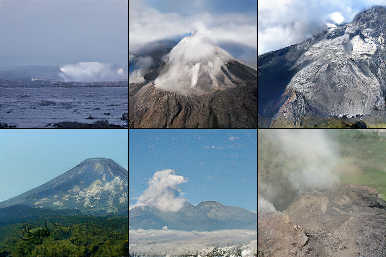

In [6]:
# Tình huống 1: Chạy với các tham số mặc định
num_samples = 64
num_rows = 2
num_cols = 3
noise_seed = 23
label_str = "980) volcano"  # Chọn label mặc định

# Tạo noise và labels
z = sampler.get_noise(num_samples, seed=noise_seed)
label = int(label_str.split(')')[0])
labels = np.asarray([label] * num_samples)

# Sinh ảnh
samples = sampler.get_samples(z, labels)

# Hiển thị hình ảnh
imshow(imgrid(samples[:6], cols=num_cols))


In [7]:
from PIL import Image
# Tình huống 1
filename1 = "scenario1_default.png"
save_samples(samples[:6], filename1, num_cols)

## Tình huống 2: Thay đổi số lượng mẫu và cách hiển thị

Samples dictionary: {'generated': array([[[[0.8171955 , 0.8346709 , 0.809006  ],
         [0.8302536 , 0.83614063, 0.84316105],
         [0.7944994 , 0.8015523 , 0.8562343 ],
         ...,
         [0.23888153, 0.30843878, 0.2149981 ],
         [0.26768652, 0.37927642, 0.3459401 ],
         [0.2733208 , 0.3240463 , 0.34632856]],

        [[0.8090001 , 0.81393087, 0.8232286 ],
         [0.80764997, 0.79507315, 0.8348675 ],
         [0.8048824 , 0.791389  , 0.8579204 ],
         ...,
         [0.29230925, 0.2884398 , 0.25482464],
         [0.3370089 , 0.39429927, 0.42235544],
         [0.3037215 , 0.31781602, 0.32604223]],

        [[0.8165741 , 0.7674409 , 0.85902286],
         [0.7927325 , 0.78834426, 0.8455433 ],
         [0.8032603 , 0.7887125 , 0.8481002 ],
         ...,
         [0.38123563, 0.2907197 , 0.20310956],
         [0.45068535, 0.37390757, 0.34834617],
         [0.43348372, 0.30796722, 0.22153232]],

        ...,

        [[0.46230757, 0.5217144 , 0.37170598],
         [0

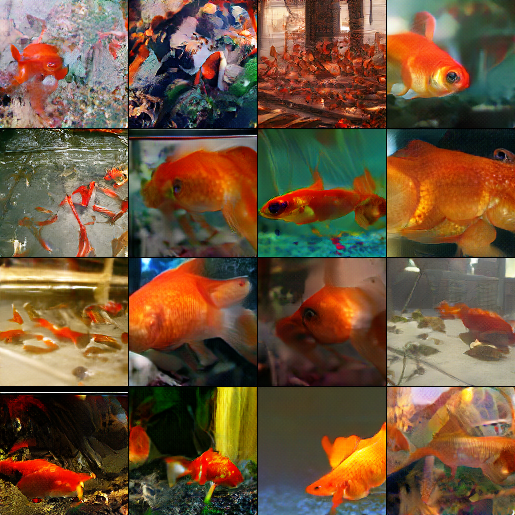

In [8]:
num_samples = 128  # Số lượng mẫu nhiều hơn
batch_size = 64  # Số mẫu mỗi batch
num_rows = 4
num_cols = 4
noise_seed = 42  # Đổi hạt giống để sinh noise mới
label_str = "1) goldfish, Carassius auratus"  # Chọn một label khác

# Tạo noise và labels
z = sampler.get_noise(num_samples, seed=noise_seed)  # Tạo noise
label = int(label_str.split(')')[0])  # Lấy nhãn
labels = np.asarray([label] * num_samples)  # Nhãn cho tất cả mẫu

# Chạy từng batch và lưu kết quả
all_samples = []  # Lưu các mẫu từ tất cả các batch
num_batches = num_samples // batch_size  # Tính số batch

for i in range(num_batches):
    # Lấy dữ liệu của batch hiện tại
    batch_z = z[i * batch_size : (i + 1) * batch_size]
    batch_labels = labels[i * batch_size : (i + 1) * batch_size]

    # Sinh mẫu cho batch hiện tại
    batch_samples = sampler.get_samples(batch_z, batch_labels)
    all_samples.append(batch_samples)

# Gộp tất cả các batch lại thành một tập hợp mẫu
samples = np.concatenate(all_samples, axis=0)

# Hiển thị hình ảnh (chỉ hiển thị 16 hình đầu tiên)
imshow(imgrid(samples[:16], cols=num_cols))  # Hiển thị 16 hình


In [9]:
from PIL import Image
# Tình huống 2
filename2 = "scenario2_changed_samples.png"
save_samples(samples[:16], filename2, num_cols)

## Tình huống 3: Sử dụng các label khác nhau

Samples dictionary: {'generated': array([[[[0.5620538 , 0.586933  , 0.56900513],
         [0.5803196 , 0.6074847 , 0.619313  ],
         [0.59904647, 0.6313623 , 0.6296641 ],
         ...,
         [0.47885007, 0.5067086 , 0.5158378 ],
         [0.45772678, 0.4946959 , 0.508435  ],
         [0.4590052 , 0.48391056, 0.48955628]],

        [[0.5532684 , 0.5405192 , 0.564909  ],
         [0.5775279 , 0.58137983, 0.61993587],
         [0.5940993 , 0.5964917 , 0.61211586],
         ...,
         [0.37099588, 0.39671797, 0.42255604],
         [0.38451162, 0.40456894, 0.42240185],
         [0.42391962, 0.4434117 , 0.46656486]],

        [[0.5657438 , 0.5317256 , 0.57917213],
         [0.651044  , 0.63506734, 0.6900978 ],
         [0.638772  , 0.63499403, 0.6558355 ],
         ...,
         [0.35050339, 0.38076574, 0.4212005 ],
         [0.36440974, 0.37241054, 0.4049358 ],
         [0.3544436 , 0.37933278, 0.40270132]],

        ...,

        [[0.9697032 , 0.97171015, 0.9715117 ],
         [0

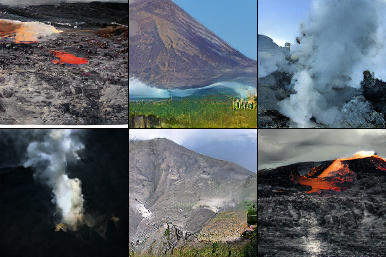

Samples dictionary: {'generated': array([[[[0.05438298, 0.08616969, 0.10048619],
         [0.03166321, 0.06721079, 0.07878509],
         [0.02824113, 0.07371619, 0.0955357 ],
         ...,
         [0.5415288 , 0.40652484, 0.18853268],
         [0.49815336, 0.3843014 , 0.25805485],
         [0.26645863, 0.20621234, 0.1056208 ]],

        [[0.07852721, 0.09145427, 0.06818235],
         [0.10814723, 0.12541902, 0.12223491],
         [0.12737533, 0.15041426, 0.15894648],
         ...,
         [0.37748927, 0.26030558, 0.15918666],
         [0.430667  , 0.34820062, 0.24042255],
         [0.25963902, 0.2502462 , 0.08750856]],

        [[0.06754562, 0.07928756, 0.11480221],
         [0.11627176, 0.14342058, 0.14139748],
         [0.1517351 , 0.17854178, 0.16076931],
         ...,
         [0.3233672 , 0.2517761 , 0.1508066 ],
         [0.4896562 , 0.38969523, 0.2126002 ],
         [0.27981946, 0.27093887, 0.06080535]],

        ...,

        [[0.9982949 , 0.9972427 , 0.9958039 ],
         [0

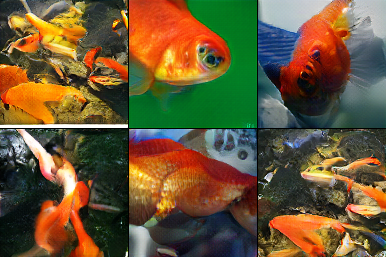

Samples dictionary: {'generated': array([[[[0.3045532 , 0.22867462, 0.09810075],
         [0.30513915, 0.20096904, 0.05327809],
         [0.7100666 , 0.46716905, 0.22194877],
         ...,
         [0.06493497, 0.04805514, 0.02515978],
         [0.07404184, 0.04656461, 0.02562228],
         [0.10915777, 0.09095579, 0.0702306 ]],

        [[0.06207785, 0.03114814, 0.00448111],
         [0.05539843, 0.03499755, 0.00408226],
         [0.90405476, 0.71765316, 0.45658657],
         ...,
         [0.02204373, 0.01694188, 0.01344842],
         [0.02674884, 0.01785475, 0.01269752],
         [0.0404292 , 0.03340456, 0.0203037 ]],

        [[0.2680177 , 0.17469588, 0.06619844],
         [0.9447566 , 0.84625113, 0.722568  ],
         [0.98590994, 0.9103502 , 0.7669061 ],
         ...,
         [0.03029525, 0.02913821, 0.02262887],
         [0.03737482, 0.02629077, 0.01985943],
         [0.03692344, 0.03225729, 0.01937333]],

        ...,

        [[0.26514083, 0.17846286, 0.09183237],
         [0

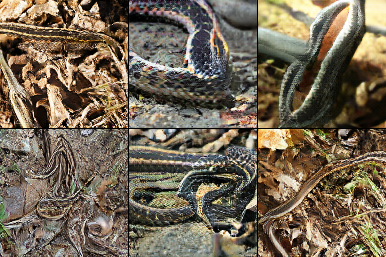

In [19]:
# Tình huống 3: Kiểm tra khả năng sinh ảnh với nhiều labels
num_samples = 64
num_rows = 2
num_cols = 3
noise_seed = 99
label_list = [980, 1, 57]  # Ba lớp: "volcano", "goldfish", "dog"

for label in label_list:
    labels = np.asarray([label] * num_samples)
    z = sampler.get_noise(num_samples, seed=noise_seed)

    # Sinh ảnh
    samples = sampler.get_samples(z, labels)

    print(f"Generated images for label {label}")
    imshow(imgrid(samples[:6], cols=num_cols))

In [11]:
from PIL import Image

# Tình huống 3
for i, label in enumerate(label_list):
    filename3 = f"scenario3_label_{label}.png"
    save_samples(samples[:6], filename3, num_cols)

In [12]:
class Discriminator(object):

  def __init__(self, module_spec):
    self._module_spec = module_spec
    self._sess = None
    self._graph = tf.Graph()
    self._load_model()

  @property
  def conditional(self):
    return "labels" in self._inputs

  @property
  def image_shape(self):
    return self._inputs["images"].shape.as_list()[1:]

  def _load_model(self):
    with self._graph.as_default():
      self._discriminator = hub.load(self._module_spec,tags={"disc", "bsNone"})
      signature = self._discriminator.signatures["default"]
      # Lấy thông tin đầu vào của mô hình
      input_info = self._discriminator.signatures['default'].structured_input_signature[1]
      self._inputs = {k: tf.placeholder(v.dtype, v.shape.as_list(), k) for k, v in input_info.items()}

      self._outputs = signature(**self._inputs)
      print("Inputs:", self._inputs)
      print("Outputs:", self._outputs)

  def _init_session(self):
    if self._sess is None:
      self._sess = tf.Session(graph=self._graph)
      self._sess.run(tf.global_variables_initializer())

  def predict(self, images, labels=None):
    with self._graph.as_default():
      self._init_session()
      feed_dict = {self._inputs["images"]: images}
      if "labels" in self._inputs:
        assert labels is not None
        assert labels.shape[0] == images.shape[0]
        feed_dict[self._inputs["labels"]] = labels
      return self._sess.run(self._outputs, feed_dict=feed_dict)

In [13]:
disc = Discriminator(module_spec)

batch_size = 4
num_classes = 1000
images = np.random.random(size=[batch_size] + disc.image_shape)
labels = np.random.randint(0, num_classes, size=(batch_size))

disc.predict(images, labels=labels)

Inputs: {'images': <tf.Tensor 'images:0' shape=(?, 128, 128, 3) dtype=float32>, 'labels': <tf.Tensor 'labels:0' shape=(?,) dtype=int32>}
Outputs: {'prediction': <tf.Tensor 'StatefulPartitionedCall_1:0' shape=(?, 1) dtype=float32>}


{'prediction': array([[0.8254678 ],
        [0.7762688 ],
        [0.88851887],
        [0.7723072 ]], dtype=float32)}

## 2. Ghi lại log từ mô hình

In [14]:
# Hàm ghi log vào file .csv
def log_results_to_csv(epoch, time_taken, filename='results_log.csv'):
    if not os.path.exists(filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Time Taken (seconds)"])  # Header

    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch, time_taken])

# Hàm lưu hình ảnh vào thư mục
def save_image_samples(samples, epoch, output_dir='generated_images'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, sample in enumerate(samples):
        image_path = os.path.join(output_dir, f"epoch_{epoch}_sample_{i}.png")
        Image.fromarray(sample).save(image_path)
        print(f"Saved image: {image_path}")


In [15]:
import time
import os
import csv

# Tình huống 1: Chạy với các tham số mặc định
num_samples = 64
num_rows = 2
num_cols = 3
noise_seed = 23
label_str = "980) volcano"  # Chọn label mặc định

# Tạo noise và labels
z = sampler.get_noise(num_samples, seed=noise_seed)
labels = np.asarray([label] * num_samples)

# Sinh ảnh
start_time = time.time()
samples = sampler.get_samples(z, labels)
end_time = time.time()

# Ghi log kết quả
time_taken = end_time - start_time
log_results_to_csv(epoch=1, time_taken=time_taken)

# Lưu hình ảnh vào thư mục
save_image_samples(samples, epoch=1)

Samples dictionary: {'generated': array([[[[0.13053358, 0.12529305, 0.09821138],
         [0.09401143, 0.0980072 , 0.06780472],
         [0.25832853, 0.22640342, 0.23417595],
         ...,
         [0.7008307 , 0.6075451 , 0.500931  ],
         [0.46753317, 0.4062519 , 0.34235662],
         [0.44766495, 0.41416687, 0.3613913 ]],

        [[0.04202512, 0.03616321, 0.01749074],
         [0.01843145, 0.01868135, 0.0089843 ],
         [0.14208469, 0.12317094, 0.07072911],
         ...,
         [0.43648607, 0.36097515, 0.26773763],
         [0.29820532, 0.27008134, 0.21854722],
         [0.26050115, 0.25638545, 0.20372063]],

        [[0.28566617, 0.21137622, 0.20570824],
         [0.17269969, 0.1474334 , 0.08993274],
         [0.66772795, 0.5321083 , 0.4455196 ],
         ...,
         [0.54018307, 0.4568362 , 0.35809237],
         [0.43524396, 0.37238643, 0.28297052],
         [0.4531369 , 0.40044627, 0.31092677]],

        ...,

        [[0.29298478, 0.24218452, 0.20960665],
         [0

In [20]:
!pwd

/content


In [21]:
!ls

all_files.zip	  sample_data			 scenario3_label_1.png
generated_images  scenario1_default.png		 scenario3_label_57.png
results_log.csv   scenario2_changed_samples.png  scenario3_label_980.png


In [22]:
# Nén toàn bộ thư mục làm việc (thư mục /content) vào một tệp .zip
!zip -r /content/all_files.zip /content/*

from google.colab import files

# Tải tệp zip về máy
files.download('/content/all_files.zip')

updating: content/generated_images/ (stored 0%)
updating: content/generated_images/epoch_1_sample_50.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_60.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_31.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_0.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_54.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_10.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_24.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_63.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_22.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_15.png (stored 0%)
updating: content/generated_images/epoch_1_sample_51.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_38.png (deflated 0%)
updating: content/generated_images/epoch_1_sample_56.png (deflated 0%)
updating: content/generated_imag

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>